# QRS Detection Algorithm
This is an implementation of the QRS detection algorithm by Pan Tompkins based on the MIT BIH Data Set

### References:
1. Pan, Jiapu, and Willis J. Tompkins. "A real-time QRS detection algorithm." IEEE transactions on biomedical engineering 3 (1985): 230-236.
2. MIT BIH Arrythmia Data Set from [Physionet](https://physionet.org/cgi-bin/atm/ATM)

### Importing Libraries
This implementation requires scipy and numpy for processing and matplotlib for plotting.<br>
These can be easily downloaded via pip as `pip install <library-name>`
### Importing Data
The Data can be downloaded in a folder with names similar to original set, e.g. "100m.mat"

In [1]:
#For general operations
import numpy as np
from scipy import signal as sig
from matplotlib import pyplot as plt
#from __future__ import print_function
% matplotlib inline

### Loading Data

The following snippet has been taken from https://gist.github.com/Nixonite/bc2f69b0c4430211bcad
This converts .mat files from physionet to .csv to be parsed in python.
Please enter the path of folder containing .mat files in path and the sample Id in the variable sampleId

In [2]:
import scipy.io
import numpy as np

path = "/home/ubuntu/ECG/"
sampleId = "117"
data = scipy.io.loadmat(path+"/"+sampleId+"m.mat") 

for i in data:
    if '__' not in i and 'readme' not in i:
        np.savetxt(("./Extract/"+sampleId+".csv"),data[i],delimiter=',')


Here, val is the variable that contains data in the .mat file. We extract the data from it to a numpy array-like 
From data, we choose the channel MVII as our data signal x. It is normalized as prescribed on physionet.
T is the samplling frequency. Here it is 360 samples/sec
N is the approximate width of expected QRS

In [3]:
data = np.loadtxt("/home/ubuntu/ECG/Extract/"+sampleId+".csv", delimiter=",").T
x = data[:,0]
x = x.astype("float")
x = (x-1024)/200
T = 360
N = 24

### Visualization

The signal is plotted to get a rough idea of how it looks using pyplot from matplotlib. 

In [4]:
print("Duration of Signal:     ",len(x)/360/60)
print("Average value of signal:", np.average(x))

Duration of Signal:      30.092592592592595
Average value of signal: -5.971854261538462


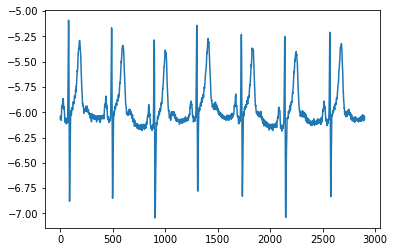

In [5]:
plt.plot(x[100:3000])

## Methods

The algorithm works based on the following sequence of methods

### 1. Band Pass Filter:
First, high frequency components are removed by a low pass filter. The input is x and output signal is x1
Its transfer function is given by H(z) = $ \frac{(1-z^{-6})^{2}} {(1-z^{-1})^{2}} \\ $

Then we add a high pass filter with a transfer function H(z) = $ \frac{(-1-32z^{-16}+z^{-32})} {(1-z^{-1})} \\ $
The signal obtained after passing x1 through this is x2




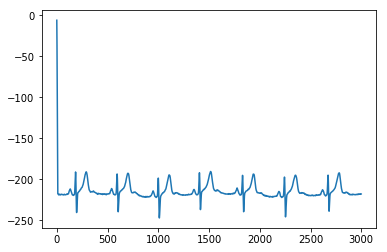

In [6]:
x1 = sig.lfilter([1,0,0,0,0,0,-2,0,0,0,0,0,1],[1,-2,1],x)
plt.plot(x1[0:3000])

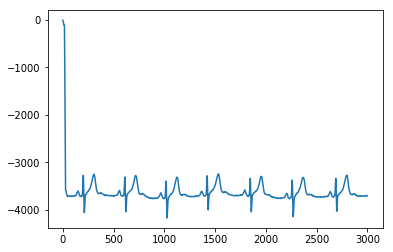

In [7]:
x2 = sig.lfilter([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],[1,1],x1)
plt.plot(x2[0:3000])

### 2. Derivative:
The signal x2 is differentiatied in discrete time based on the transfer function $ H(z) = \frac{(-z^{-2}-2z^{-1}+2z^{1}+z^{2})}{8T} $ to get $ x_3$

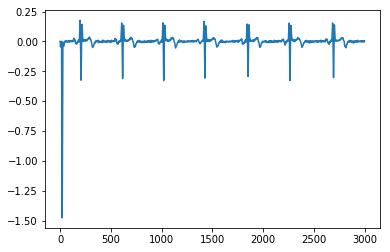

In [8]:
x3 = np.zeros(x.shape)
for i in range(2,len(x2)-2):
    x3[i] = (-1*x2[i-2] -2*x2[i-1] + 2*x2[i+1] + x2[i+2])/(8*T)
plt.plot(x3[:3000])

### 3. Squaring:
This step simply squares each term as $y[nt] = x[nt]^{2} $ and returns signal $ x_4 $

(Not in paper) We also remove outliers which are beyond twice of standard deviation above the average value and make them as zero. This

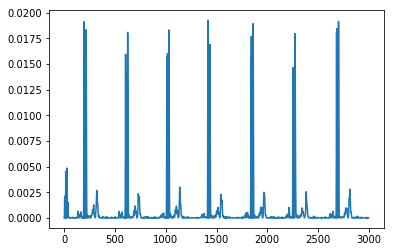

In [9]:
x4 = x3*x3
av = np.average(x4)
std = np.std(x4)
for i in range(len(x4)):
    if(x4[i]>=av+2*std):
        x4[i] = 0
plt.plot(x4[:3000])
#print(av,std)

### 5. Moving Window Average:
A moving window average is taken with window size N as defined previously.
$ y[nt] = \frac {\sum_{k=0}^{(N-1)} x[nT - kT]} {N} $

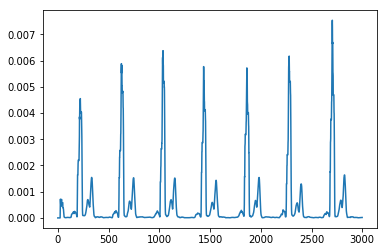

In [10]:
x5 = np.zeros(x.shape)
for i in range(N,len(x4)-N):
    for j in range(N):
        x5[i]+= x4[i-j]
x5 = x5/N
plt.plot(x5[:3000])

## Thresholding
### Noise Signal:
We will consider the noise to be the part that was removed after bandpass filter. For this we define noise as $x_n = \frac {x - x_2}{32*36}$ where 32 and 36 are gains of the filters applied. We can also try outlier removal if necessary.
### Peaks and Averages:
The variable $peaki$ will denote the running max value of the signal $x_5$ and
$spki$ will denote the running average of the signal $x_5$ <br>
While the variable $spki$ will denote the running average of the signal $x_5$ 
### Updation:
After each ieration, the value of $spki = 0.125*peaki + 0.875*spki$ <br>
Similarly, the value of $npki = 0.125*peaki + 0.875*npki$
### Initial Thresholding:
Threshold values can be found based on the formula $NPKI + 0.25(SPKI - NPKI)$ and the other will be half of first
Peaks can thus be detected. And we can check for peaks in regions where 166% beyond average shows no peak

0.0014619462870268996 0.008913523003101304


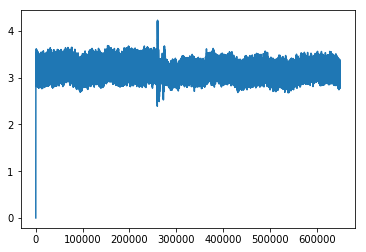

In [11]:
xn = (x - x2)/(36*32)

# av = np.average(xn)
# std = np.std(xn)
# for i in range(len(x2)):
#     if(xn[i]>=av+2*std) or (xn[i]<=av-2*std):
#         xn[i] = 0
#xn = xn-av

plt.plot(xn)
print(av,std)

In [12]:
peaki = x5[0]
spki = 0
npki = 0
c=0
peak = [0]
threshold1 = spki
pk = []
for i in range(1,len(x5)):
    if x5[i]>peaki:
        peaki = x5[i]
                     
    npki = ((npki*(i-1))+xn[i])/i
    spki = ((spki*(i-1))+x5[i])/i
    spki = 0.875*spki + 0.125*peaki
    npki = 0.875*npki + 0.125*peaki
    
    threshold1 = npki + 0.25*(spki-npki)
    threshold2 = 0.5 * threshold1

    if(x5[i]>=threshold2):
        #print("Andar")
        if(peak[-1]+N<i):
            peak.append(i)
            pk.append(x5[i])
            
print("NPKI: ",npki)
print("SPKI: ",spki)
print("Threshold I1: ",threshold1)
print("Threshold I2: ",threshold2)
print("Number of peaks is: ",len(peak))      


NPKI:  0.008817824679747323
SPKI:  0.008784671930617136
Threshold I1:  0.008809536492464777
Threshold I2:  0.0044047682462323885
Number of peaks is:  1254


### Final Thresholding:
This is learning phase II where remaining signals can be identified and counted. Procedure similar to first

In [13]:
peak2 = np.array(peak)
avg = np.average(np.diff(peak))
thresholdf1 = 0
thresholdf2 = 0
peakf = x5[0]
spkf = 0
npkf = 0
for i in range(1,len(peak)):
    peakf = x5[i-1]
    spkf = 0
    npkf = 0
    if(peak[i]-peak[i-1]>=1.66*avg): 
        for j in range(int(peak[i-1])+1,int(peak[i])):
            if x5[j]>peakf:
                peakf = x5[j]
            npkf = ((npkf*(j-1))+xn[j])/j
            spkf = ((spkf*(j-1))+x5[j])/j
            spkf = 0.875*spkf + 0.125*peakf
            npkf = 0.875*npkf + 0.125*peakf
            #print(x5[j],thresholdf1,thresholdf2)
            
            thresholdf1 = (npkf + 0.25*(spkf-npkf))
            thresholdf2 = 0.5 * thresholdf1

            if(x5[j]>=thresholdf2):
                if(peak2[-1]< j):
                    print("Andar")
                    peak.append(j)
                    pk.append(x5[j])
                    
print("NPKF: ",npkf)
print("SPKF: ",spkf)
print("Threshold F1: ",thresholdf1)
print("Threshold F2: ",thresholdf2)
print("Number of peaks is: ",len(peak))      

NPKF:  0
SPKF:  0
Threshold F1:  0.006406706257426868
Threshold F2:  0.003203353128713434
Number of peaks is:  1254


## Result
### Beats:

In [14]:
print("Average samples per beat", np.average(np.diff(peak)))

Average samples per beat 518.7222665602554


In [15]:
bpm = np.average(np.diff(np.array(peak)))*60.0/T
print("Heart rate in BPM:",bpm)

Heart rate in BPM: 86.4537110933759


### Peaks:

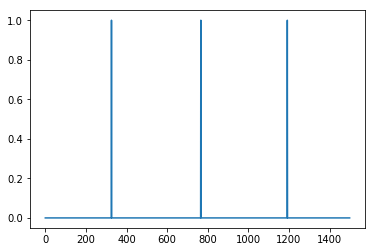

In [18]:
#peak
p = np.zeros(len(x5))
for i in peak:
    p[i]=1
plt.plot(p[4500:6000])
#len(peak)

## Future Work

### Other Possible Methods:
Peaks could't be very accurately found with this methods. Below are other methods that may work for finding peaks with minor tweaks

In [ ]:
p_sig = sig.find_peaks_cwt(x5, np.arange(1,N))
peak_sig = []
prev = p_sig[0]
# for i in p_sig:
#     if(i>(prev+N)):
#         peak_sig.append(i)
#     prev = i
# np.diff(np.array(peak_sig))

p = np.zeros(len(x5))
for i in p_sig:
    p[i]=1

plt.plot(p[:3000])
len(p_np)

In [ ]:
p_np = np.array(list(sig.argrelextrema(x5,np.greater)))
p = np.zeros(len(x5))
for i in p_np:
    p[i]=1
plt.plot(p[:3000])
len(p_np[0])